<h1><center>Credit Risk Analysis</center></h1>
 

### imports

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.utils import shuffle
import time

import warnings
warnings.filterwarnings('ignore')


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

# Dataset Visualization


Let's take a quick look at the dataset.


In [3]:
cust_pd_full = pd.read_csv('./data/CUST_HISTORY_1000.csv')

# rows=1000
cust_pd = cust_pd_full # .head(rows)
print("There are " + str(len(cust_pd_full)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd_full.columns)) + " variables in the dataset.")

cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 19 variables in the dataset.


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES,No
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO,No
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO,No


# Distribution of data w.r.t Defaulting

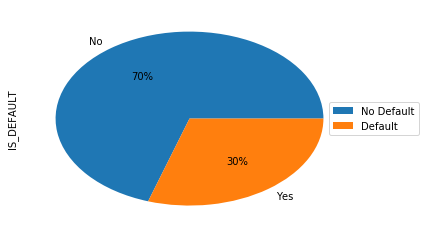

In [4]:
#cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',colormap='winter',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))
cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(('No Default', 'Default'), bbox_to_anchor=(1.2, 0.6))

# Default by Transaction Category

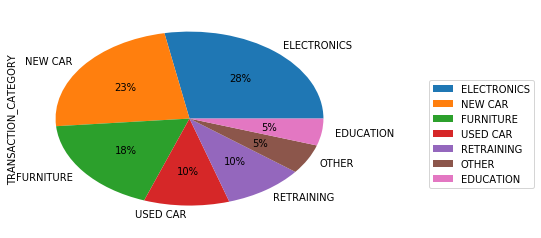

In [5]:
cust_pd.TRANSACTION_CATEGORY.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.7))

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23%) & Furniture(18%).

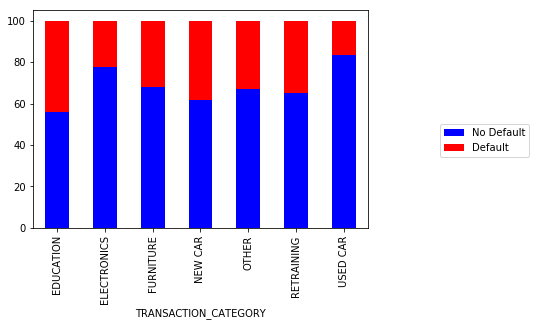

In [6]:
defaults_by_credit_program = cust_pd.groupby(['TRANSACTION_CATEGORY','IS_DEFAULT']).size()
percentages = defaults_by_credit_program.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(('No Default', 'Default'), bbox_to_anchor=(1.2, 0.5))

* Top 3 credit programs with high default rate are Education, New Car and Retraining

# Default rate  - Owning Residence

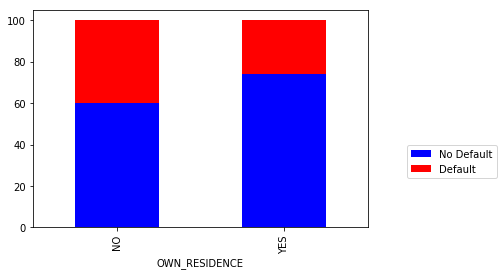

In [7]:
defaults_by_rent = cust_pd.groupby(['OWN_RESIDENCE','IS_DEFAULT']).size()
percentages = defaults_by_rent.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(('No Default', 'Default'),bbox_to_anchor=(1.4, 0.4))

From this stacked bar chart, we can see that Merchants who rent their residence have higher default rate.

# Defaults w.r.t Credit History

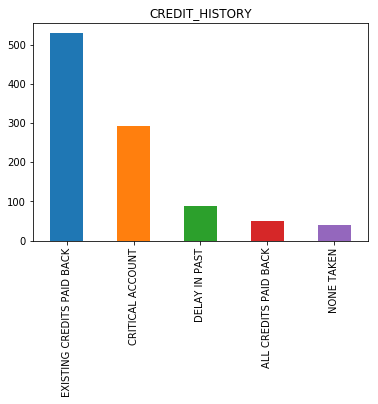

In [8]:
cust_pd.CREDIT_HISTORY.value_counts().plot(kind='bar', title='CREDIT_HISTORY')

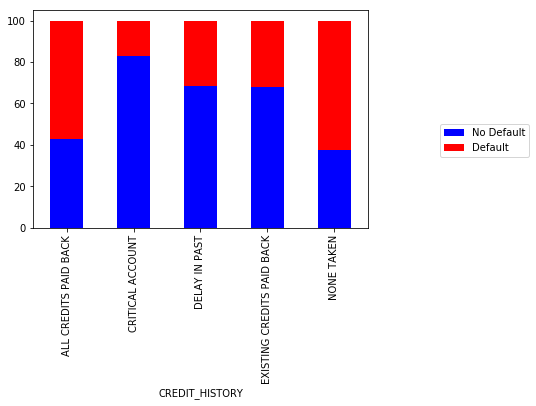

In [9]:
defaults_by_history = cust_pd.groupby(['CREDIT_HISTORY','IS_DEFAULT']).size()
percentages = defaults_by_history.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(('No Default', 'Default'),bbox_to_anchor=(1.2, 0.5))

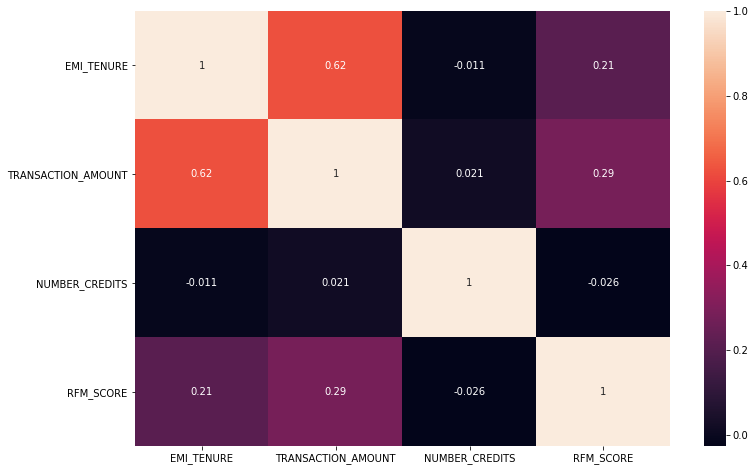

In [10]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);

# Data Preparation

In [11]:
cust_pd.head()

,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES,No
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO,No
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO,No


## Split Dataframe into Features and Label

In [12]:
cust_pd_Y = cust_pd[['IS_DEFAULT']]
cust_pd_X = cust_pd.drop(['IS_DEFAULT'],axis=1)

print('cust_pd_X.shape=%s, cust_pd_Y.shape=%s'% (cust_pd_X.shape, cust_pd_Y.shape))


cust_pd_X.shape=(1000, 18), cust_pd_Y.shape=(1000, 1)


## Transform Label

In [13]:
cust_pd_Y.head()

,IS_DEFAULT
0,No
1,No
2,No
3,No
4,No


In [14]:
le = LabelEncoder()
cust_pd_Y['IS_DEFAULT'] = le.fit_transform(cust_pd_Y['IS_DEFAULT'])
cust_pd_Y.head()

,IS_DEFAULT
0,0
1,0
2,0
3,0
4,0


## Transform Features

In [15]:
print(f'features df shape = {cust_pd_X.shape}')
cust_pd_X.head()

features df shape = (1000, 18)


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO


### Label Encoder for categorical Columns

In [16]:
categoricalColumns = ['CREDIT_HISTORY', 'TRANSACTION_CATEGORY', 'ACCOUNT_TYPE', 'ACCOUNT_AGE',
                      'STATE', 'IS_URBAN', 'IS_STATE_BORDER', 'HAS_CO_APPLICANT', 'HAS_GUARANTOR',
                      'OWN_REAL_ESTATE', 'OTHER_INSTALMENT_PLAN',
                      'OWN_RESIDENCE', 'RFM_SCORE', 'OWN_CAR', 'SHIP_INTERNATIONAL']
cat_indexes =  [cust_pd_X.columns.get_loc(col) for col in categoricalColumns]
cat_indexes = np.asarray(cat_indexes)   # .ravel()

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelList=[]
labelEncoderList={}
for col in categoricalColumns:
    labenc = LabelEncoder()
    cust_pd_X[col] = labenc.fit_transform(cust_pd_X[col]) 
    labelEncoderList[col] = labenc
    newclas = [col + "_" + str(clas).replace(' ', '_') for clas in labenc.classes_ ]
    labelList.append(np.asarray(newclas))
labelEncoded_X = cust_pd_X
cust_pd_X.head()

,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,12,1,3,2171,4,0,2,0,1,0,0,0,1,1,2,1,0,1
1,36,1,6,5800,4,0,0,0,1,0,0,0,0,1,2,2,1,0
2,18,1,1,1169,2,0,2,0,1,0,0,0,0,1,2,2,1,0
3,36,2,6,8947,2,1,0,0,1,0,0,0,1,1,1,3,1,0
4,21,3,1,2606,4,4,2,0,0,0,0,0,0,0,1,3,1,0


In [18]:
collabelList = np.concatenate( labelList, axis=0 )

### One hot encoding for categorical Columns

In [19]:
OH_enc = OneHotEncoder(categorical_features=cat_indexes, handle_unknown='ignore', n_values="auto")
OH_enc.fit(cust_pd_X.values)

OneHotEncoder(categorical_features=array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17]),
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', sparse=True)

In [20]:
newcols = np.append(collabelList, ["EMI_TENURE", "TRANSACTION_AMOUNT", "NUMBER_CREDITS"])

In [21]:
cust_pd_X_enc = OH_enc.transform(cust_pd_X)
cust_pd_X_df = pd.DataFrame(cust_pd_X_enc.toarray(), columns=newcols)
cust_pd_X_df.head()

,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CRITICAL_ACCOUNT,CREDIT_HISTORY_DELAY_IN_PAST,CREDIT_HISTORY_EXISTING_CREDITS_PAID_BACK,CREDIT_HISTORY_NONE_TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW_CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED_CAR,ACCOUNT_TYPE_100_to_500_K_USD,ACCOUNT_TYPE_500_to_1000_K_USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above_1000_K_USD,ACCOUNT_TYPE_up_to_100_K_USD,ACCOUNT_AGE_1_to_4_YRS,ACCOUNT_AGE_4_to_7_YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above_7_YRS,ACCOUNT_AGE_up_to_1_YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,2171.0,2.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,36.0,5800.0,2.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,18.0,1169.0,2.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,36.0,8947.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,21.0,2606.0,1.0


### Feature Normalization 

In [22]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(cust_pd_X_df)
features = min_max_scaler.transform(cust_pd_X_df)
features = normalize(features, axis=1, norm='l1')

cust_pd_X = pd.DataFrame(features,columns=newcols)
cust_pd_X.head()

,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CRITICAL_ACCOUNT,CREDIT_HISTORY_DELAY_IN_PAST,CREDIT_HISTORY_EXISTING_CREDITS_PAID_BACK,CREDIT_HISTORY_NONE_TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW_CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED_CAR,ACCOUNT_TYPE_100_to_500_K_USD,ACCOUNT_TYPE_500_to_1000_K_USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above_1000_K_USD,ACCOUNT_TYPE_up_to_100_K_USD,ACCOUNT_AGE_1_to_4_YRS,ACCOUNT_AGE_4_to_7_YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above_7_YRS,ACCOUNT_AGE_up_to_1_YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS
0,0.0,0.064281,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.064281,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.064281,0.064281,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.064281,0.0,0.064281,0.0,0.000000,0.064281,0.064281,0.0,0.064281,0.0,0.064281,0.0,0.000000,0.064281,0.000000,0.064281,0.0,0.064281,0.000000,0.000000,0.064281,0.000000,0.000000,0.064281,0.007562,0.006795,0.021427
1,0.0,0.062076,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.062076,0.0,0.0,0.000000,0.0,0.062076,0.062076,0.000000,0.0,0.0,0.000000,0.062076,0.0,0.000000,0.0,0.062076,0.0,0.000000,0.062076,0.062076,0.0,0.062076,0.0,0.062076,0.0,0.062076,0.000000,0.000000,0.062076,0.0,0.000000,0.062076,0.000000,0.000000,0.062076,0.062076,0.000000,0.029212,0.018957,0.020692
2,0.0,0.064145,0.000000,0.000000,0.0,0.0,0.064145,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.064145,0.0,0.000000,0.064145,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.064145,0.0,0.064145,0.0,0.000000,0.064145,0.064145,0.0,0.064145,0.0,0.064145,0.0,0.064145,0.000000,0.000000,0.064145,0.0,0.000000,0.064145,0.000000,0.000000,0.064145,0.064145,0.000000,0.013206,0.003244,0.021382
3,0.0,0.000000,0.062699,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.062699,0.0,0.0,0.062699,0.0,0.000000,0.000000,0.062699,0.0,0.0,0.000000,0.062699,0.0,0.000000,0.0,0.062699,0.0,0.000000,0.062699,0.062699,0.0,0.062699,0.0,0.062699,0.0,0.000000,0.062699,0.000000,0.062699,0.0,0.000000,0.000000,0.062699,0.000000,0.062699,0.062699,0.000000,0.029506,0.030004,0.000000
4,0.0,0.000000,0.000000,0.065021,0.0,0.0,0.065021,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.065021,0.000000,0.000000,0.0,0.0,0.065021,0.000000,0.0,0.065021,0.0,0.065021,0.0,0.065021,0.000000,0.065021,0.0,0.065021,0.0,0.065021,0.0,0.065021,0.000000,0.065021,0.000000,0.0,0.000000,0.000000,0.065021,0.000000,0.065021,0.065021,0.000000,0.016255,0.008429,0.000000


## Split Train and Test Dataset

In [23]:
label    = cust_pd_Y.values
features  = cust_pd_X.values

label = np.reshape(label,(-1,1))
# label = np.float32(label)
X_train,X_test,y_train,y_test = \
       train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
print(f'X_train.shape={X_train.shape} Y_train.shape={y_train.shape}')
print(f'X_test.shape={X_test.shape} Y_test.shape={y_test.shape}')

X_train.shape=(700, 51) Y_train.shape=(700, 1)
X_test.shape=(300, 51) Y_test.shape=(300, 1)


# Sklearn Training

In [24]:
# Import
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression(verbose=1)

In [25]:
# TRAIN
t0 = time.time()
sklearn_lr.fit(X_train, y_train)
print("[sklearn] Training time (s):  {0:.5f}".format(time.time()-t0))


[LibLinear][sklearn] Training time (s):  0.00461


In [26]:
# Evaluate log-loss on test set
# proba_test = sklearn_lr.predict_proba(X_test)
# from sklearn.metrics import log_loss
# logloss_sklearn = log_loss(y_test, proba_test)
# print("[sklearn] Logarithmic loss:   {0:.4f}".format(logloss_sklearn))
sklearn_prediction = sklearn_lr.predict(X_test)
print(f'sklearn ml accuracy score = {accuracy_score(y_test,sklearn_prediction)}')

sklearn ml accuracy score = 0.7


### Prediction

In [27]:
import operator
def predict_listTopFeatures(X, model, colNames):
    mult = X.values[0]*model.coef_
    prediction = model.predict(X.values)
    prediction_prob = model.predict_proba(X.values)

    print("Possibility for defaulting : {} - confidence {:.1f}%".format(
        le.classes_[int(prediction[0])], prediction_prob[0][int(prediction[0])] * 100))
    print()
    print("Key Features which contributes to this outcome: ")
    # Risk free - 0
    if int(prediction[0]) == 0:
        indx = np.where((mult < 0 ))
        negvalues = np.extract((mult < 0 ), mult)
        listwithindex = list(zip(indx[1], negvalues))
        listwithindex.sort(key = operator.itemgetter(1))
        for x in listwithindex[:3]:
            print(colNames[x[0]])
    else:
        indx = np.where((mult > 0 ))
        posvalues = np.extract((mult > 0 ), mult)
        listwithindex = list(zip(indx[1], posvalues))
        listwithindex.sort(key = operator.itemgetter(1), reverse = True)
        for x in listwithindex[:3]:
            print(colNames[x[0]])
            
def process_testDF(test_data, catColumns, labelEncs,
                      onehotEnc, mm_scaler, colNames):
       test_data_X_ = test_data
       for col in catColumns:
           labenc = labelEncs[col]
           test_data_X_[col] = labenc.transform(test_data_X_[col]) 
       test_data_X1_enc = onehotEnc.transform(test_data_X_)

       test_data_X1_enc = pd.DataFrame(test_data_X1_enc.toarray(),columns=newcols)
       features = mm_scaler.transform(test_data_X1_enc)
       features = normalize(features, axis=1, norm='l1')

       test_data_X1_ndf = pd.DataFrame(features,columns=colNames)
       return test_data_X1_ndf



### Predict & List Top Features which influences the outcome

In [28]:
RecNum = 3
test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
Actual=cust_pd['IS_DEFAULT'].iloc[[RecNum]]

test_data_X1_ndf = process_testDF(test_data,
                                    categoricalColumns, labelEncoderList, OH_enc,
                                    min_max_scaler, newcols
                                    )

predict_listTopFeatures(test_data_X1_ndf, sklearn_lr, newcols)
print("\nActual : {}".format(Actual.values))

Possibility for defaulting : No - confidence 72.2%

Key Features which contributes to this outcome: 
ACCOUNT_TYPE_UNKNOWN/NONE
OWN_RESIDENCE_YES
ACCOUNT_AGE_4_to_7_YRS

Actual : ['No']


In [29]:
labEnc = labelEncoderList['TRANSACTION_CATEGORY']
trans_cat = labEnc.classes_

In [30]:
from ipywidgets import *
import random

style = {'description_width': 'initial'}

RecNum = 3
test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
DELAY_IN_PAST = widgets.Checkbox(value=True if test_data['CREDIT_HISTORY'].values == "DELAY IN PAST" else False,
                                 description='DELAY IN PAST')
TRANSACTION_AMOUNT = widgets.FloatSlider(min=1e3, max=5e4, step=1e3,
                                         description='TRANSACTION AMOUNT', 
                                         value=test_data['TRANSACTION_AMOUNT'].values,
                                         continuous_update=False, style=style,
                                         layout=Layout(width='50%'))
TRANSACTION_CATEGORY = widgets.Dropdown(options=trans_cat,
                                        value=test_data['TRANSACTION_CATEGORY'].values,
                                        description='TRANSACTION CATEGORY', 
                                        style=style, layout=Layout(width='50%'))
EMI_TENURE = widgets.IntSlider(min=12, max=240, step=5,
                                         description='EMI TENURE in months', 
                                         value=test_data['EMI_TENURE'].values,
                                         continuous_update=False, style=style,
                                         layout=Layout(width='50%'))
ui = widgets.VBox([DELAY_IN_PAST, TRANSACTION_AMOUNT, TRANSACTION_CATEGORY, EMI_TENURE],
                  layout=Layout(padding='10px 10px 10px 10px', border='solid'))



def fpredict(DELAY_IN_PAST, TRANSACTION_AMOUNT, TRANSACTION_CATEGORY, EMI_TENURE):
    test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
    test_data['TRANSACTION_AMOUNT'] = TRANSACTION_AMOUNT
    test_data['EMI_TENURE'] = EMI_TENURE
    test_data['TRANSACTION_CATEGORY'] = TRANSACTION_CATEGORY
    test_data['CREDIT_HISTORY'] = "DELAY IN PAST" if DELAY_IN_PAST else "EXISTING CREDITS PAID BACK"
    
    test_data_X1_ndf = process_testDF(test_data,
                                    categoricalColumns, labelEncoderList, OH_enc,
                                    min_max_scaler, newcols
                                    )

    predict_listTopFeatures(test_data_X1_ndf, sklearn_lr, newcols)
     
    
out = widgets.interactive_output(fpredict,{'DELAY_IN_PAST': DELAY_IN_PAST,
                                           'TRANSACTION_AMOUNT' : TRANSACTION_AMOUNT,
                                           'TRANSACTION_CATEGORY': TRANSACTION_CATEGORY,
                                           'EMI_TENURE': EMI_TENURE})

display(ui, out)
button = widgets.Button(description="Pick Random Data!")
display(button)
label = widgets.Label(description="")
display(label)

def randomizeData(b):
    global RecNum
    global test_data
    RecNum = random.randint(1,500)
    test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
    Actual=cust_pd.iloc[[RecNum]]['IS_DEFAULT']
    amt = test_data['TRANSACTION_AMOUNT']
    cat = test_data['TRANSACTION_CATEGORY']
    past = test_data['CREDIT_HISTORY']
    tenure = test_data['EMI_TENURE']
    label.value="Actual : {} ".format(Actual.values)
    TRANSACTION_AMOUNT.value = amt
    DELAY_IN_PAST.value = True if test_data['CREDIT_HISTORY'].values == "DELAY IN PAST" else False
    TRANSACTION_CATEGORY.value = cat.values
    EMI_TENURE.value = tenure.values
    

button.on_click(randomizeData)

Output()

Button(description='Pick Random Data!', style=ButtonStyle())

Label(value='')

## Further Analysis

### Check how good is our Model

In [31]:
features_order = labelEncoded_X.columns.tolist()
labelEncoded_X.head()

,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,12,1,3,2171,4,0,2,0,1,0,0,0,1,1,2,1,0,1
1,36,1,6,5800,4,0,0,0,1,0,0,0,0,1,2,2,1,0
2,18,1,1,1169,2,0,2,0,1,0,0,0,0,1,2,2,1,0
3,36,2,6,8947,2,1,0,0,1,0,0,0,1,1,1,3,1,0
4,21,3,1,2606,4,4,2,0,0,0,0,0,0,0,1,3,1,0


In [32]:
# Process the data without Onehot Encoder as RandomForest works best with Categorical columns
min_max_scaler_ = MinMaxScaler()
cust_pd_X_ = min_max_scaler_.fit_transform(labelEncoded_X)
cust_pd_X_ = normalize(cust_pd_X_, axis=1, norm='l1')
cust_pd_X_ = pd.DataFrame(cust_pd_X_,columns=features_order)

features_  = cust_pd_X_.values
label_    = cust_pd_Y.values

label_ = np.reshape(label_,(-1,))

X_train_,X_test_,y_train_,y_test_ = \
       train_test_split(features_, label_, test_size=0.3, random_state=42, stratify=label_)

In [33]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

#Stratify split and train on 5 folds
skf = StratifiedKFold(y_train_, n_folds=5)
counter = 1
for train_fold, test_fold in skf:
    random_forest.fit(X_train_[train_fold], y_train_[train_fold])
    print( str(counter) + ": ", random_forest.score(X_train_[test_fold], y_train_[test_fold]))
    counter += 1 

1:  0.65
2:  0.7428571428571429
3:  0.7
4:  0.7
5:  0.6928571428571428


### List Top feature which influence the Model

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_, y_train_)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(5):    # range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features_order[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature EMI_TENURE (0.102374)
2. feature CREDIT_HISTORY (0.089283)
3. feature TRANSACTION_AMOUNT (0.087708)
4. feature ACCOUNT_TYPE (0.081653)
5. feature RFM_SCORE (0.078388)
